In [2]:
# Setup and Imports
# Core
import os, re, sys, math, warnings
warnings.filterwarnings('ignore')

# Data
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
# Optional: seaborn for nicer plots if available
try:
    import seaborn as sns
except Exception:
    sns = None

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Optional: XGBoost (if installed)
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

print('Versions -> pandas', pd.__version__, '| numpy', np.__version__)

Versions -> pandas 2.2.2 | numpy 2.0.2


In [4]:
# Load Data
# Path to data
DATA_PATH = 'bikes.csv'  # change if needed

if not os.path.exists(DATA_PATH):
    print(f'⚠️ Data file not found at {DATA_PATH}. Please place your CSV there.')
else:
    df = pd.read_csv(DATA_PATH)
    print('✅ Loaded:', df.shape)
    display(df.head(10))

✅ Loaded: (7857, 8)


,model_name,model_year,kms_driven,owner,location,mileage,power,price
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,first owner,hyderabad,\n\n 35 kmpl,19 bhp,63500
1,Royal Enfield Classic 350cc 2016,2016,50000 Km,first owner,hyderabad,\n\n 35 kmpl,19.80 bhp,115000
2,Hyosung GT250R 2012,2012,14795 Km,first owner,hyderabad,\n\n 30 kmpl,28 bhp,300000
3,Bajaj Dominar 400 ABS 2017,2017,Mileage 28 Kms,first owner,pondicherry,\n\n 28 Kms,34.50 bhp,100000
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,\n\n,30 bhp,197500
5,KTM Duke 200cc 2012,2012,24561 Km,third owner,bangalore,\n\n 35 kmpl,25 bhp,63400
6,Bajaj Pulsar 180cc 2016,2016,19718 Km,first owner,bangalore,\n\n 65 kmpl,17 bhp,55000
7,TVS Apache RTR 200 4V Dual Channel ABS BS6 2020,2020,Mileage 40 Kmpl,first owner,hyderabad,\n\n 40 Kmpl,20.21 bhp,120000
8,KTM Duke 390cc 2018,2018,1350 Km,first owner,jaipur,\n\n 25 kmpl,42.90 bhp,198000
9,Yamaha FZ16 150cc 2014,2014,Mileage 58 Kmpl,first owner,bangalore,\n\n 58 Kmpl,13 bhp,40000


In [5]:
# quick data overview
if 'df' in globals():
    print('Shape:', df.shape)
    print('\nColumns:', list(df.columns))
    print('\nInfo:')
    print(df.info())
    display(df.describe(include='all').T)

Shape: (7857, 8)

Columns: ['model_name', 'model_year', 'kms_driven', 'owner', 'location', 'mileage', 'power', 'price']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7857 entries, 0 to 7856
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   model_name  7857 non-null   object
 1   model_year  7857 non-null   int64 
 2   kms_driven  7857 non-null   object
 3   owner       7857 non-null   object
 4   location    7838 non-null   object
 5   mileage     7846 non-null   object
 6   power       7826 non-null   object
 7   price       7857 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 491.2+ KB
None


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
model_name,7857,1724,Royal Enfield Classic 350cc 2017,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_year,7857.0,NaN,NaN,NaN,2015.367698,4.001443,1950.0,2014.0,2016.0,2018.0,2021.0
kms_driven,7857,1801,Mileage 65 Kmpl,436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
owner,7857,4,first owner,6817,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,7838,561,delhi,1438,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,7846,117,\n\n 35 kmpl,1071,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,7826,272,19.80 bhp,922,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,7857.0,NaN,NaN,NaN,106791.336897,138926.124628,0.0,42000.0,75000.0,125000.0,3000000.0


In [6]:
# Data Cleaning - Types ,Units,Missings , Duplicates
if 'df' in globals():
    # Standardize column names (lowercase, underscores)
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

    # Strip whitespace in string columns
    for c in df.select_dtypes(include='object').columns:
        df[c] = df[c].astype(str).str.strip()

    # Helper: extract first number from a text like '150 cc', '13 bhp', '45 kmpl'
    def extract_num(x):
        if pd.isna(x):
            return np.nan
        m = re.search(r'([0-9]+\.?[0-9]*)', str(x))
        return float(m.group(1)) if m else np.nan

    # Parse common unit-bearing columns if present
    for col, new_col in [('cc', 'cc'), ('mileage', 'mileage_kmpl'), ('power', 'power_bhp')]:
        if col in df.columns:
            df[new_col] = df[col].apply(extract_num)

    # Convert model_year to int and compute bike_age
    from datetime import datetime
    CURR_YEAR = datetime.now().year
    if 'model_year' in df.columns:
        df['model_year'] = pd.to_numeric(df['model_year'], errors='coerce')
        df['bike_age'] = CURR_YEAR - df['model_year']

    # kms_driven to numeric
    if 'kms_driven' in df.columns:
        df['kms_driven'] = pd.to_numeric(df['kms_driven'].astype(str).str.replace(',', ''), errors='coerce')

    # Drop duplicates
    before = df.shape[0]
    df.drop_duplicates(inplace=True)
    after = df.shape[0]
    print(f'Duplicates removed: {before - after}')

    # Missing summary
    miss = df.isna().mean().sort_values(ascending=False)
    display(miss.to_frame('missing_rate'))

Duplicates removed: 140


,missing_rate
kms_driven,1.000000
mileage_kmpl,0.099002
power_bhp,0.004017
model_year,0.000000
model_name,0.000000
owner,0.000000
location,0.000000
power,0.000000
mileage,0.000000
price,0.000000


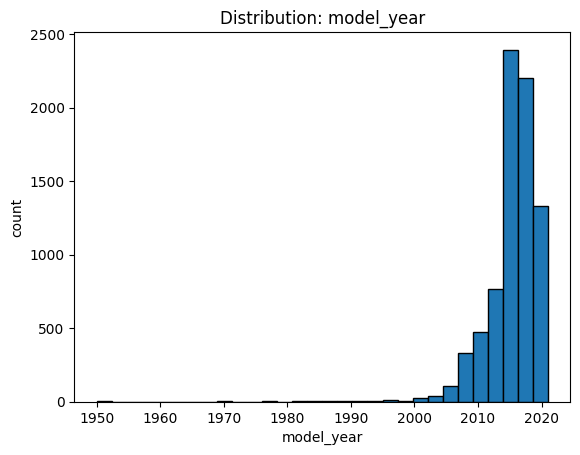

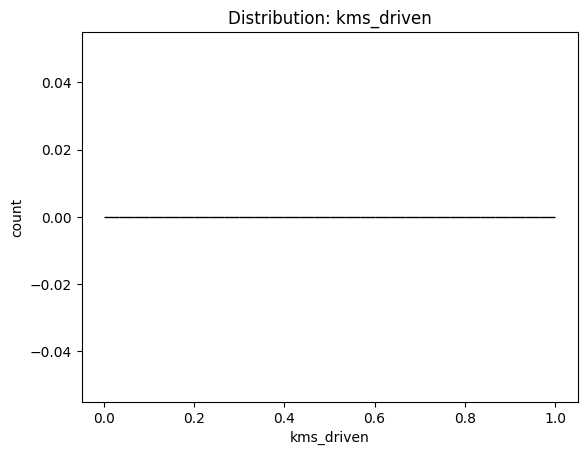

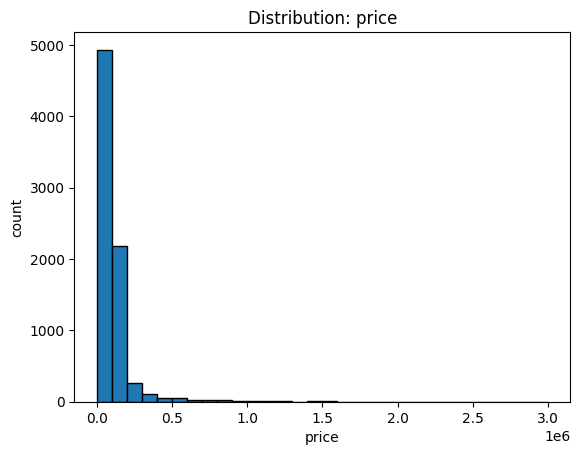

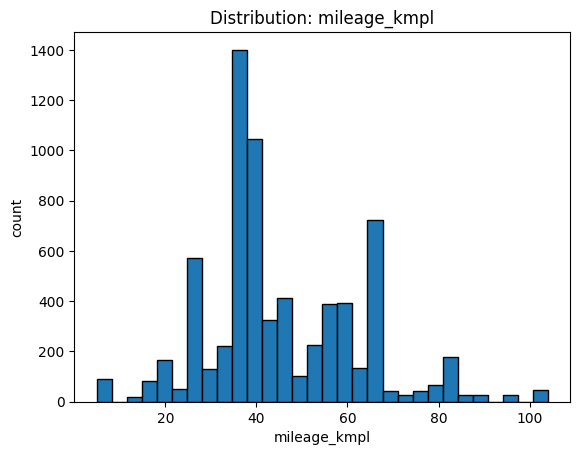

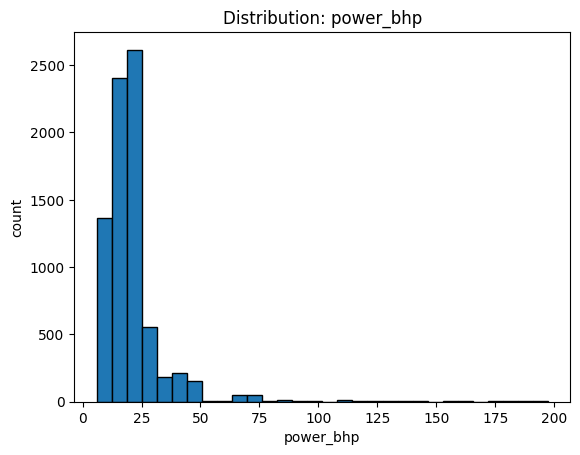

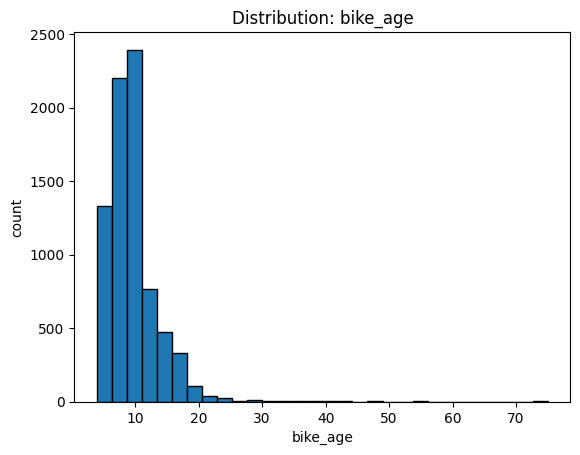

In [7]:
# EDA univariate
if 'df' in globals():
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    for c in num_cols[:10]:  # sample first 10 numeric cols
        plt.figure()
        df[c].dropna().plot(kind='hist', bins=30, edgecolor='black')
        plt.title(f'Distribution: {c}')
        plt.xlabel(c)
        plt.ylabel('count')
        plt.show()

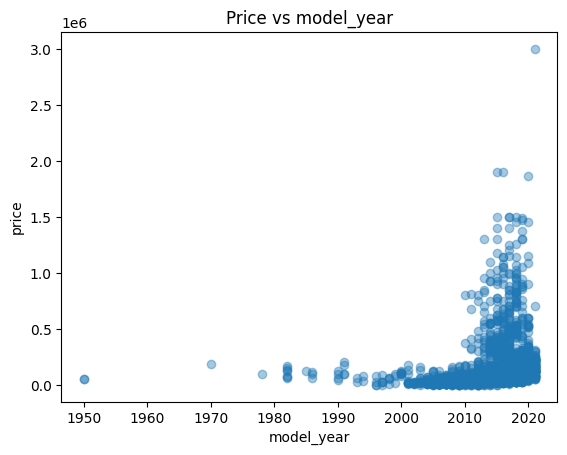

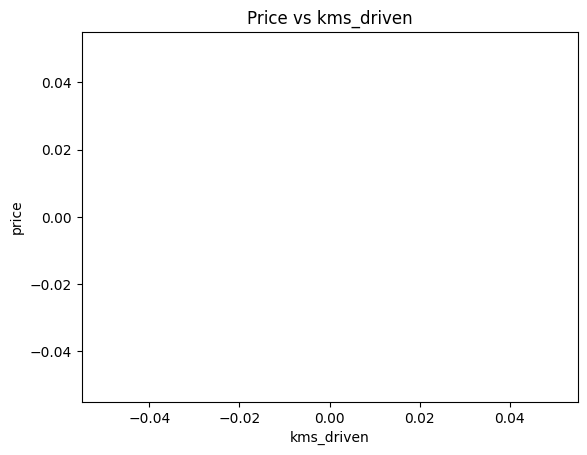

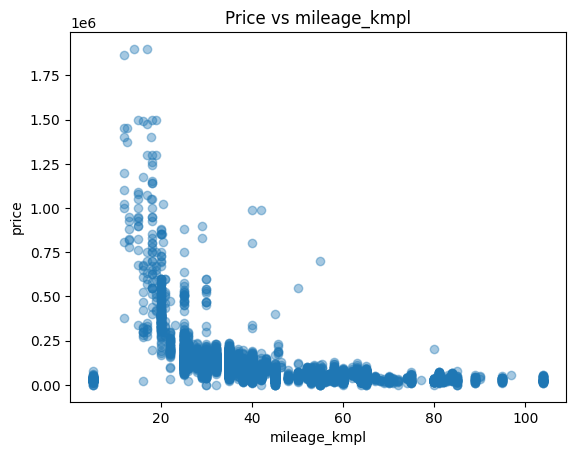

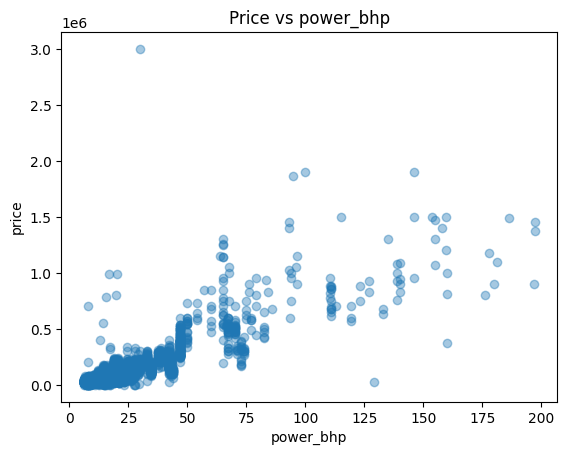

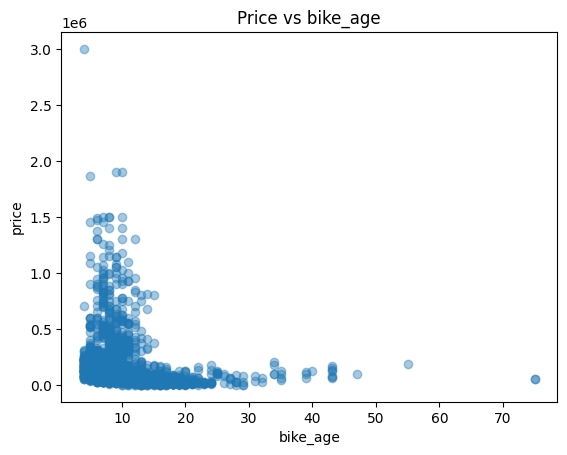

In [8]:
# EDA bivariate (price relationship)
if 'df' in globals() and 'price' in df.columns:
    candidates = [c for c in df.select_dtypes(include=np.number).columns if c != 'price']
    for c in candidates[:8]:  # limit for speed
        plt.figure()
        plt.scatter(df[c], df['price'], alpha=0.4)
        plt.title(f'Price vs {c}')
        plt.xlabel(c)
        plt.ylabel('price')
        plt.show()

,model_year,kms_driven,price,mileage_kmpl,power_bhp,bike_age
model_year,1.000000,NaN,0.227430,-0.164994,0.153224,-1.000000
kms_driven,NaN,NaN,NaN,NaN,NaN,NaN
price,0.227430,NaN,1.000000,-0.468721,0.832205,-0.227430
mileage_kmpl,-0.164994,NaN,-0.468721,1.000000,-0.561200,0.164994
power_bhp,0.153224,NaN,0.832205,-0.561200,1.000000,-0.153224
bike_age,-1.000000,NaN,-0.227430,0.164994,-0.153224,1.000000


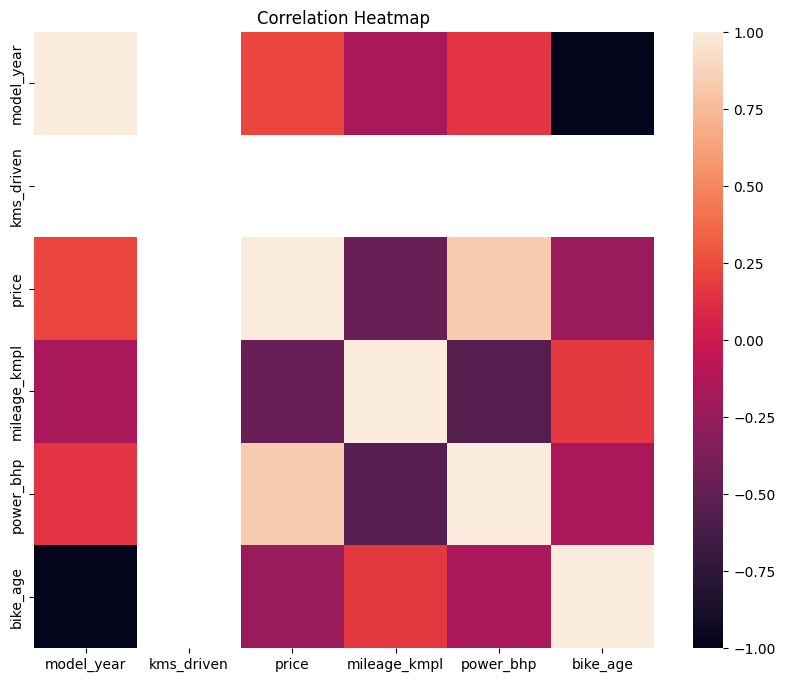

In [9]:
# EDA correlation (numeric only)
if 'df' in globals():
    num_df = df.select_dtypes(include=np.number)
    if num_df.shape[1] > 1:
        corr = num_df.corr()
        display(corr)
        # Simple correlation heatmap if seaborn available
        if sns is not None:
            plt.figure(figsize=(10,8))
            sns.heatmap(corr, annot=False)
            plt.title('Correlation Heatmap')
            plt.show()

In [10]:
# featuring engineering
if 'df' in globals():
    # Example additional features
    if set(['price','kms_driven']).issubset(df.columns):
        df['price_per_km'] = df['price'] / df['kms_driven'].replace(0, np.nan)

    # Owner as ordered category (example mapping — adjust per dataset values)
    if 'owner' in df.columns:
        order_map = {
            'first_owner': 1, '1st_owner': 1, 'first': 1,
            'second_owner': 2, '2nd_owner': 2, 'second': 2,
            'third_owner': 3, '3rd_owner': 3, 'third': 3,
            'fourth_owner': 4, '4th_owner': 4, 'fourth': 4,
            'others': 5
        }
        df['owner_clean'] = df['owner'].str.lower().map(order_map)

    display(df.head(10))

,model_name,model_year,kms_driven,owner,location,mileage,power,price,mileage_kmpl,power_bhp,bike_age,price_per_km,owner_clean
0,Bajaj Avenger Cruise 220 2017,2017,NaN,first owner,hyderabad,35 kmpl,19 bhp,63500,35.0,19.00,8,NaN,NaN
1,Royal Enfield Classic 350cc 2016,2016,NaN,first owner,hyderabad,35 kmpl,19.80 bhp,115000,35.0,19.80,9,NaN,NaN
2,Hyosung GT250R 2012,2012,NaN,first owner,hyderabad,30 kmpl,28 bhp,300000,30.0,28.00,13,NaN,NaN
3,Bajaj Dominar 400 ABS 2017,2017,NaN,first owner,pondicherry,28 Kms,34.50 bhp,100000,28.0,34.50,8,NaN,NaN
4,Jawa Perak 330cc 2020,2020,NaN,first owner,bangalore,,30 bhp,197500,NaN,30.00,5,NaN,NaN
5,KTM Duke 200cc 2012,2012,NaN,third owner,bangalore,35 kmpl,25 bhp,63400,35.0,25.00,13,NaN,NaN
6,Bajaj Pulsar 180cc 2016,2016,NaN,first owner,bangalore,65 kmpl,17 bhp,55000,65.0,17.00,9,NaN,NaN
7,TVS Apache RTR 200 4V Dual Channel ABS BS6 2020,2020,NaN,first owner,hyderabad,40 Kmpl,20.21 bhp,120000,40.0,20.21,5,NaN,NaN
8,KTM Duke 390cc 2018,2018,NaN,first owner,jaipur,25 kmpl,42.90 bhp,198000,25.0,42.90,7,NaN,NaN
9,Yamaha FZ16 150cc 2014,2014,NaN,first owner,bangalore,58 Kmpl,13 bhp,40000,58.0,13.00,11,NaN,NaN


In [15]:
# train/test split  & preprocessing pipeline
from sklearn.impute import SimpleImputer

if 'df' in globals() and 'price' in df.columns:
    # Target
    y = df['price'].astype(float)

    # Feature candidates
    drop_candidates = [c for c in ['price'] if c in df.columns]
    X = df.drop(columns=drop_candidates)

    # Identify numeric and categorical
    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

    # Preprocess
    numeric_tf = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Impute missing numeric values
        ('scaler', StandardScaler())
    ])
    categorical_tf = Pipeline(steps=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_tf, num_cols),
            ('cat', categorical_tf, cat_cols)
        ]
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print('Train/Test shapes:', X_train.shape, X_test.shape)

Train/Test shapes: (6173, 12) (1544, 12)


In [19]:
def eval_reg_model(name, model, X_train, X_test, y_train, y_test, preprocessor):
    pipe = Pipeline(steps=[('pre', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, preds)
    mae  = mean_absolute_error(y_test, preds)
    r2   = r2_score(y_test, preds)
    print(f'{name}: RMSE={rmse:.2f} | MAE={mae:.2f} | R2={r2:.3f}')
    return {'name': name, 'rmse': rmse, 'mae': mae, 'r2': r2}, pipe

if 'X_train' in globals():
    results = []
    models = [
        ('LinearRegression', LinearRegression()),
        ('RandomForest', RandomForestRegressor(random_state=42)),
        ('GradientBoosting', GradientBoostingRegressor(random_state=42))
    ]
    if HAS_XGB:
        from xgboost import XGBRegressor
        models.append(('XGBRegressor', XGBRegressor(random_state=42)))

    fitted = {}
    for name, mdl in models:
        res, pipe = eval_reg_model(name, mdl, X_train, X_test, y_train, y_test, preprocessor)
        results.append(res)
        fitted[name] = pipe

    print("\nModel Comparison:")
    display(pd.DataFrame(results).sort_values('rmse'))

LinearRegression: RMSE=4460162076.51 | MAE=22947.22 | R2=0.674
RandomForest: RMSE=3091542108.13 | MAE=17375.50 | R2=0.774
GradientBoosting: RMSE=3177045733.09 | MAE=22246.96 | R2=0.768
XGBRegressor: RMSE=7013088331.61 | MAE=18734.02 | R2=0.488

Model Comparison:


,name,rmse,mae,r2
1,RandomForest,3.091542e+09,17375.503197,0.774172
2,GradientBoosting,3.177046e+09,22246.956254,0.767926
0,LinearRegression,4.460162e+09,22947.219940,0.674199
3,XGBRegressor,7.013088e+09,18734.018805,0.487715


In [21]:
# hyperparameter tuning (Example : Random forest)
if 'X_train' in globals():
    rf = Pipeline(steps=[('pre', preprocessor), ('model', RandomForestRegressor(random_state=42))])
    param_grid = {
        'model__n_estimators': [100, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
    }
    grid = GridSearchCV(rf, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print('Best params:', grid.best_params_)
    print('Best CV RMSE:', -grid.best_score_)

    # Test set evaluation
    best_model = grid.best_estimator_
    preds = best_model.predict(X_test)
    print('Test RMSE:', mean_squared_error(y_test, preds))
    print('Test R2:', r2_score(y_test, preds))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best CV RMSE: 65239.397890551794
Test RMSE: 2860837527.2263584
Test R2: 0.7910244609764719
